In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from conditional_rate_matching.models.generative_models.crm import CRM
from conditional_rate_matching.configs.experiments_configs.crm.crm_experiments_Cifar import experiment_cifar10_config
from conditional_rate_matching.models.pipelines.sdes_samplers.samplers import TauLeaping
from conditional_rate_matching import results_path
from torchvision.utils import make_grid

from conditional_rate_matching.configs.experiments_configs.crm.crm_experiments_Cifar import experiment_cifar10_config
from conditional_rate_matching.models.pipelines.thermostat.crm_thermostat_config import (ConstantThermostatConfig, 
                                                                                         ExponentialThermostatConfig,
                                                                                         )

In [3]:
def generate_samples(crm:CRM, 
                     x_test,
                     num_timesteps=100, 
                     time_epsilon=0.0,
                     device="cpu"):
    
    crm.config.pipeline.time_epsilon = time_epsilon
    crm.config.pipeline.num_intermediates = num_timesteps
    crm.config.pipeline.number_of_steps = num_timesteps

    x_1, x_t, t = crm.pipeline(x_test.shape[0], 
                               return_intermediaries=True, 
                               train=False, 
                               x_0=x_test)
    
    x_1 = x_1.view(-1, 3, 32, 32)
    x_t = x_t.view(-1, x_t.shape[1], 3, 32, 32)
    return x_1, x_t, t

In [4]:
def cifar_noise_bridge(crm, 
                       x_input, 
                       num_timesteps=1000,  
                       time_epsilon=0.0,
                       num_img=5,
                       num_timesteps_displayed=20,
                       save_path=None):
    
    img_1, img_hist, time_steps = generate_samples(crm, x_input[:num_img], num_timesteps=num_timesteps,  time_epsilon=time_epsilon, device=x_input.device)
    _, axs = plt.subplots(num_img, num_timesteps_displayed+2, figsize=(num_timesteps_displayed, num_img))
    N = img_hist.size(1)
    dt = N // num_timesteps_displayed

    img_1 = img_1 / img_1.max()  # Normalize to [0, 1] if necessary
    img_hist = img_hist / img_hist.max()  # Normalize to [0, 1] if necessary

    
    for j, idx in enumerate(np.arange(0, N+1, dt)):
        if j<num_timesteps_displayed:
            tau = time_steps[idx]
            images = img_hist[:, idx, :]
        else:
            tau = time_steps[-1]
            images = img_hist[:, -1, :]
            
        for i in range(num_img):
            img = images[i].detach().cpu().numpy()
            axs[i, j].imshow(img.squeeze().transpose(1, 2, 0) , cmap='gray')
            if i == 0: axs[i, j].set_title(r'$\tau = {0}$'.format(round(tau.item(),2)))
            axs[i, j].axis('off')
    
    j = num_timesteps_displayed + 1
    for i in range(num_img):
        axs[i, j].imshow(img_1[i].detach().cpu().numpy().squeeze().transpose(1, 2, 0) , cmap='gray')
        axs[i, j].axis('off')

    plt.tight_layout()
    if save_path is None: plt.show()
    else: plt.savefig(save_path+'/bridge_example.png')

In [114]:
def cifar_conditional_bridge(crm:CRM,
                             source, 
                             target, 
                             thermostat_params=.1,
                             figsize=None, 
                             num_timesteps=100,
                             num_timesteps_displayed=10,
                             save_path=None):
    
    
    config = crm.config

    crm.forward_rate.thermostat.gamma = thermostat_params
    config.thermostat = ConstantThermostatConfig()
    config.thermostat.gamma = thermostat_params

    crm.pipeline.config.thermostat.gamma = thermostat_params
    crm.config.pipeline.number_of_steps = num_timesteps
    crm.config.pipeline.num_intermediates = num_timesteps

    rate_model = lambda x, t: crm.forward_rate.conditional_transition_rate(x, target.view(-1, 3*32*32), t)
    img_1, img_hist, img_hist_max, _ = TauLeaping(crm.config, rate_model, source.view(-1, 3*32*32), forward=True)

    N = img_hist.size(1)
    dt = N // num_timesteps_displayed

    num_img = source.shape[0]
    img_1 = img_1.view(-1, 3, 32, 32)
    img_hist = img_hist.view(-1, N, 3, 32, 32)
    img_1 = img_1.long()
    img_hist = img_hist.long()

    _, axs = plt.subplots(num_img, num_timesteps_displayed+2, figsize=(num_timesteps_displayed, num_img) if figsize is None else figsize)

    for j, idx in enumerate(np.arange(0, N+1, dt)):
        if j < num_timesteps_displayed:
            images = img_hist[:, idx, :]
        else:
            images = img_hist[:, -1, :]
            
        for i in range(num_img):
            img = images[i].detach().cpu().numpy().transpose(1, 2, 0)  # Reorder dimensions to (height, width, channels)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
    
    j = num_timesteps_displayed + 1
    for i in range(num_img):
        axs[i, j].imshow(img_1[i].detach().cpu().numpy().transpose(1, 2, 0))  # Adjust this line similarly
        axs[i, j].axis('off')

    plt.tight_layout()
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path + '/conditional_markov_example.png')
    
    img_hist_max = img_hist_max.reshape(img_hist.shape).long()
    return img_1,img_hist,img_hist_max

In [6]:
def get_cifar10_test_samples(crm, 
                            which = 'source', # 'source' or 'target
                            class_label=None, 
                            sample_size=800, 
                            device="cpu"):

    images = []
    source = crm.dataloader_0.test()
    target = crm.dataloader_1.test()
    
    for batch in source if which == 'source' else target:
        if len(batch) == 2:
            sample, labels = batch[0], batch[1]
            selected_images = sample[labels == class_label] if class_label is not None else sample 
            images.append(selected_images)
        else:
            sample = batch[0].view(-1, 3, 32, 32)
            images.append(sample)

    return torch.cat(images, dim=0)[:sample_size].to(device) #if labeled else torch.tensor(images, device=device)

In [7]:
def image_grid(sample, save_path='.', num_img=5, nrow=8, figsize=(10,10)):
    _, _= plt.subplots(1,1, figsize=figsize)
    sample = sample[:num_img]
    sample = sample / sample.max()
    img = make_grid(sample, nrow=nrow)
    npimg = np.transpose(img.detach().cpu().numpy(),(1,2,0))
    plt.imshow(npimg)
    plt.axis('off')
    plt.savefig(save_path+'/selected_sample.png')
    plt.show()

# EMNIST $\to$ MNIST

In [8]:
config = experiment_cifar10_config()
crm = CRM(config=config)

Files already downloaded and verified
Files already downloaded and verified


constant thermostat with: $\gamma=0.5$:

source data:

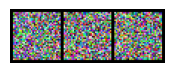

In [9]:
path = "crm_cifar10"
source_NOISE = get_cifar10_test_samples(crm, which='source', sample_size=3, device="cpu")
image_grid(source_NOISE, nrow=3, num_img=3, figsize=(2,1))

target data:

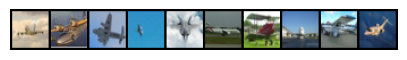

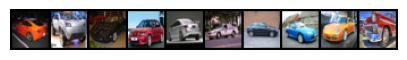

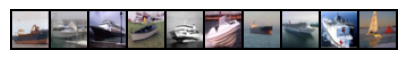

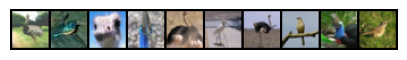

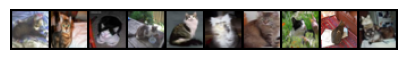

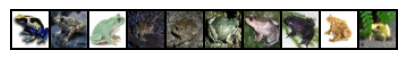

In [10]:
path = "crm_cifar10"
device = "cpu"
AIRPLANE = get_cifar10_test_samples(crm, which='target', class_label=0, sample_size=10, device=device)
CAR = get_cifar10_test_samples(crm, which='target', class_label=1, sample_size=10, device=device)
SHIP = get_cifar10_test_samples(crm, which='target', class_label=8, sample_size=10, device=device)
BIRD = get_cifar10_test_samples(crm, which='target', class_label=2, sample_size=10, device=device)
CAT = get_cifar10_test_samples(crm, which='target', class_label=3, sample_size=10, device=device)
FROG = get_cifar10_test_samples(crm, which='target', class_label=6, sample_size=10, device=device)

image_grid(AIRPLANE, nrow=10, num_img=10, figsize=(5,5))
image_grid(CAR, nrow=10, num_img=10, figsize=(5,5))
image_grid(SHIP, nrow=10, num_img=10, figsize=(5,5))

image_grid(BIRD, nrow=10, num_img=10, figsize=(5,5))
image_grid(CAT, nrow=10, num_img=10, figsize=(5,5))
image_grid(FROG, nrow=10, num_img=10, figsize=(5,5))

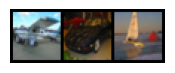

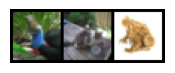

In [16]:
source_TRANSPORT = torch.cat([AIRPLANE[-2].unsqueeze(0), CAR[2].unsqueeze(0), SHIP[-1].unsqueeze(0)], dim=0)  
image_grid(source_TRANSPORT, nrow=3, num_img=3, figsize=(2,1))

target_ANIMALS = torch.cat([BIRD[8].unsqueeze(0), CAT[3].unsqueeze(0), FROG[-2].unsqueeze(0)], dim=0)  
image_grid(target_ANIMALS, nrow=3, num_img=3, figsize=(2,1))

# Markov interpolators

0it [00:00, ?it/s]

50it [00:11,  4.29it/s]


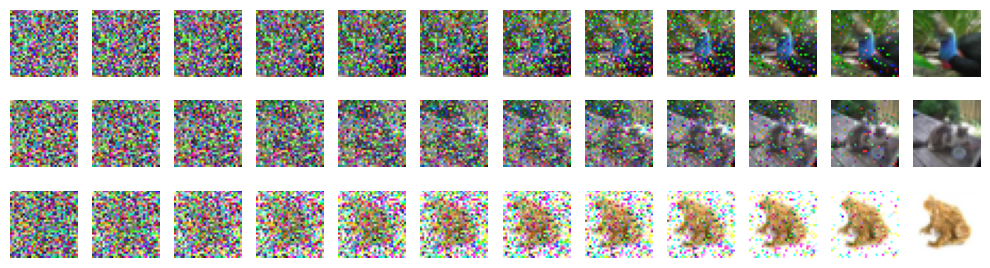

In [144]:
#cifar_conditional_bridge(crm,source_NOISE, target_ANIMALS, thermostat="constant", thermostat_params=(1.0, 0.0), num_timesteps=50, num_timesteps_displayed=10)
im_max,img_hist, img_hist_max = cifar_conditional_bridge(crm,source_NOISE, target_ANIMALS, thermostat_params=0.001, num_timesteps=50, num_timesteps_displayed=10)

In [138]:
img_hist_max.shape

torch.Size([3, 50, 3, 32, 32])

In [139]:
CAT[1,:,:,:].shape

torch.Size([3, 32, 32])

In [131]:
#im_max[0,:,:,:]

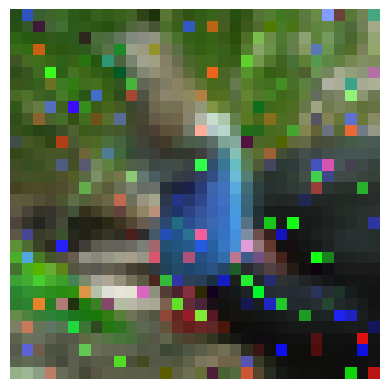

In [145]:
#image_to_plot = im_max[0,:,:,:]
image_to_plot = img_hist[0,-1,:,:,:]
#image_to_plot = img_hist_max[0,0,:,:]
#image_to_plot = CAT[1,:,:,:]
image_to_plot = image_to_plot.permute(1, 2, 0)  # Now shape is (32, 32, 3)
image_to_plot = image_to_plot.numpy()

plt.imshow(image_to_plot)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

## Generated images from CRM

Files already downloaded and verified
Files already downloaded and verified


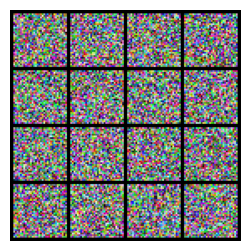

In [2]:
path = "crm_cifar10"
noise = get_cifar10_test_samples(path, which='source', sample_size=16, device="cuda:0")
image_grid(noise, nrow=4, num_img=16, figsize=(3,3))